**Load Dataset**

In [6]:
# Install geopandas for geospatial analysis
!pip install geopandas folium
!pip install kaggle

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smmmmmmmm","key":"7b133f9532960b035175029dd9cafb37"}'}

In [22]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d parisrohan/nyc-taxi-trip-duration
!unzip nyc-taxi-trip-duration.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/parisrohan/nyc-taxi-trip-duration
License(s): CC0-1.0
nyc-taxi-trip-duration.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nyc-taxi-trip-duration.zip
replace nyc_taxi_trip_duration.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [23]:
df = pd.read_csv("nyc_taxi_trip_duration.csv")

# Basic information about the dataset
df.info()
df.describe()
df.head()

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_

**Exploratory Data Analysis**


---


Distribution of Trip Durations

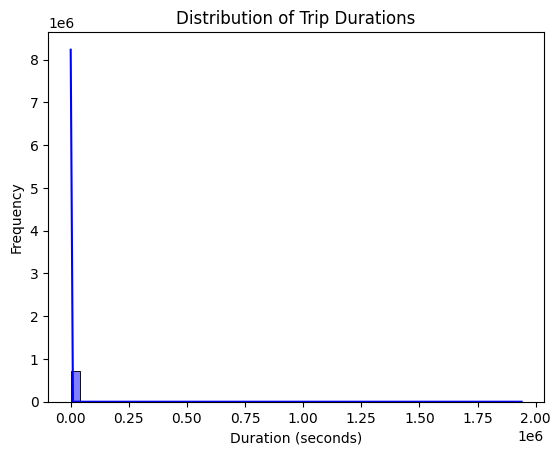

In [ ]:
# Trip duration distribution
sns.histplot(df['trip_duration'], bins=50, kde=True, color='blue')
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

Log-Transformed Distribution of Trip Durations

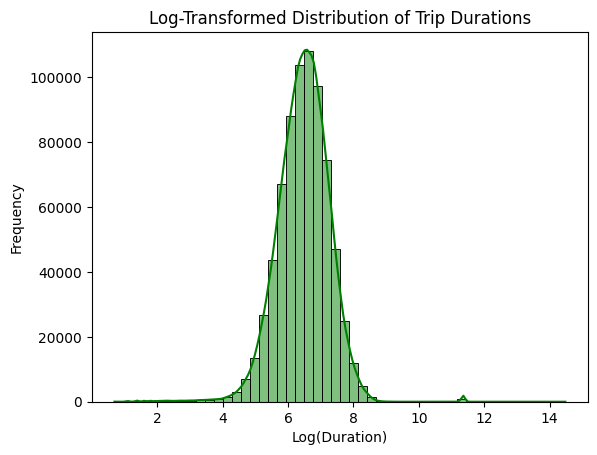

In [17]:
# Log-transform trip duration for better visualization
df['log_trip_duration'] = np.log1p(df['trip_duration'])
sns.histplot(df['log_trip_duration'], bins=50, kde=True, color='green')
plt.title('Log-Transformed Distribution of Trip Durations')
plt.xlabel('Log(Duration)')
plt.ylabel('Frequency')
plt.show()

Trips by Hour of Day

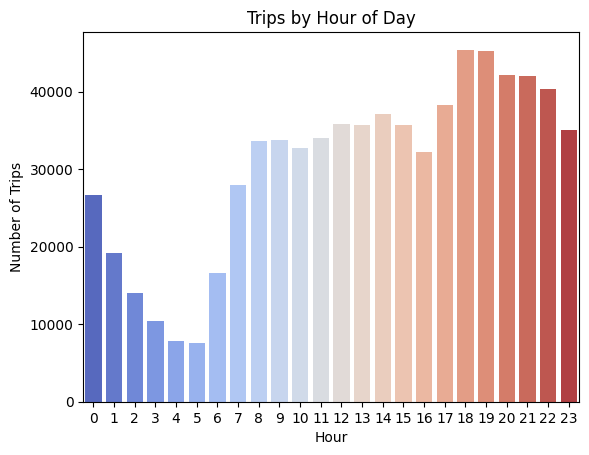

In [ ]:
# Convert pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Hourly trends
df['hour'] = df['pickup_datetime'].dt.hour
sns.countplot(x='hour', data=df, palette='coolwarm')
plt.title('Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.show()

Trips by Day of Week

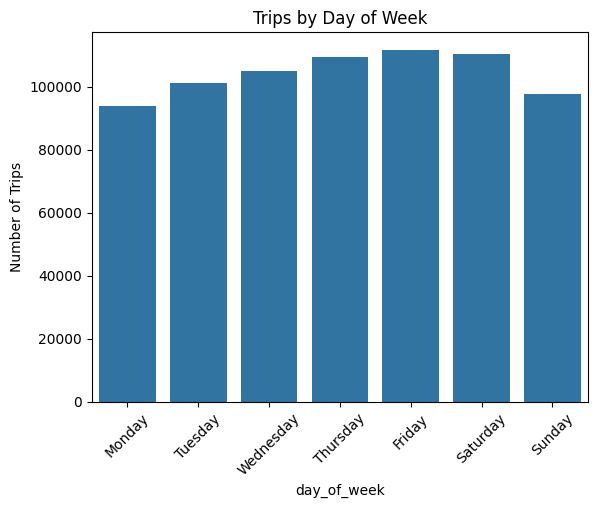

In [ ]:
# Daily trends
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
sns.countplot(x='day_of_week', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Trips by Day of Week')
plt.xticks(rotation=45)
plt.ylabel('Number of Trips')
plt.show()

Geospatial Analysis

In [10]:
# Plot pickup locations on a map
pickup_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for i in range(0, len(df), 1000):  # Sample for performance
    folium.CircleMarker(
        [df['pickup_latitude'].iloc[i], df['pickup_longitude'].iloc[i]],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.4
    ).add_to(pickup_map)

pickup_map.save("pickup_locations.html")  # Save and view in browser


Feature Engineering

In [11]:
from geopy.distance import geodesic

# Calculate distance between pickup and drop-off
def haversine_distance(lat1, lon1, lat2, lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geodesic(coords_1, coords_2).km

df['distance_km'] = df.apply(lambda row: haversine_distance(
    row['pickup_latitude'], row['pickup_longitude'],
    row['dropoff_latitude'], row['dropoff_longitude']
), axis=1)

# Encode categorical variables
df = pd.get_dummies(df, columns=['vendor_id', 'store_and_fwd_flag'], drop_first=True)

# Drop irrelevant columns
df.drop(['id', 'pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)


**Machine Learning Models**


---

Data Preprocessing

In [18]:
# Define features and target
X = df.drop(columns=['trip_duration', 'log_trip_duration'])
y = df['log_trip_duration']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Training


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Ordinal encode "day_of_week" if present
if 'day_of_week' in categorical_cols:
    ordinal_encoder = OrdinalEncoder(categories=[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']])
    X_train['day_of_week'] = ordinal_encoder.fit_transform(X_train[['day_of_week']])
    X_test['day_of_week'] = ordinal_encoder.transform(X_test[['day_of_week']])
    categorical_cols = categorical_cols.drop('day_of_week', errors='ignore')

# One-hot encoding for other categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    predictions = model.predict(X_test_processed)

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    print(f"Model: {name}")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")
    print("-" * 30)


Model: Linear Regression
MAE: 0.46, RMSE: 0.64, R2: 0.36
------------------------------
Model: Random Forest
MAE: 0.31, RMSE: 0.45, R2: 0.67
------------------------------


Predictions vs Actual

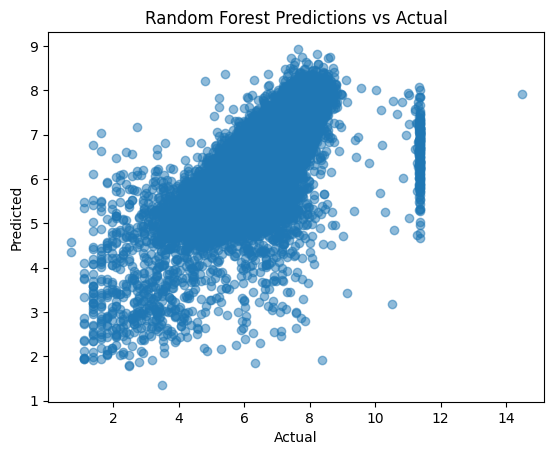

In [20]:
# Plot predictions vs actual
plt.scatter(y_test, model.predict(X_test), alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"{name} Predictions vs Actual")
plt.show()
